#Temat projektu
### Każdego roku na świecie odbywa się wiele przelotów, zarówno pasażerskich jak i towarowych.

 Dodatkowa minuta spędzona w powietrzu oznacza koszty
związane z paliwem, czy wynagrodzeniem załogi. Spóźnienia natomiast
powodują nieprzyjemności zarówno dla pasażerów, jak i przewoźników.
Czy można je przewidzieć?

### Biblioteki użyte w projekcie:

In [1]:
!pip install Basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 37.0 MB/s 
     |████████████████████████████████| 219 kB 44.0 MB/s 
     |████████████████████████████████| 30.5 MB 2.4 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=bedac20aefd580c6a41b0a69c77f3584dd6a76be9e4e89324a490310c5ed5595
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime, warnings, scipy
from collections import OrderedDict
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from matplotlib import rcParams
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

###Wczytanie plików csv z Kaggle

In [9]:
!pip install kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          13556        393  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1425         78  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           2428         81  1.0              
devansodariya/student-performance-data       

In [12]:
!kaggle datasets download -d usdot/flight-delays

 96% 184M/191M [00:05<00:00, 31.7MB/s]
100% 191M/191M [00:05<00:00, 34.0MB/s]


In [13]:
!unzip flight-delays.zip

Archive:  flight-delays.zip
  inflating: airlines.csv            
  inflating: airports.csv            
  inflating: flights.csv             


In [144]:
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv')

In [195]:
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [145]:
flights.shape

(5819079, 31)

### Przedstawienie lotnisk na mapie 

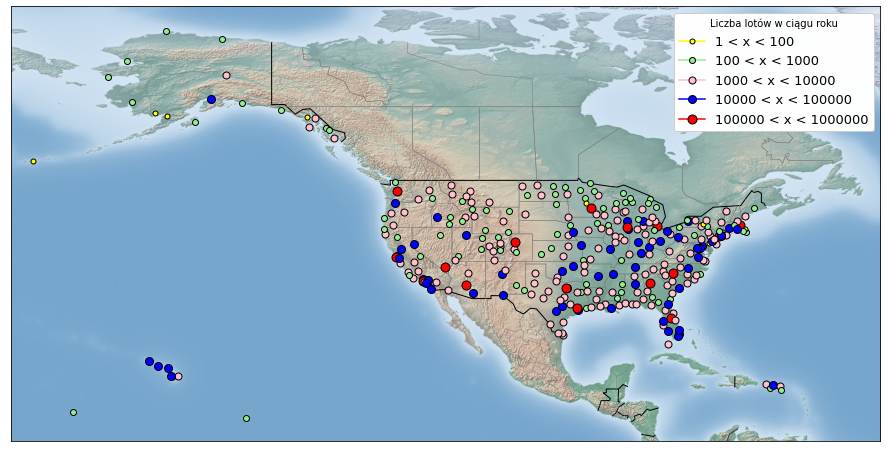

In [127]:
count_flights = flights['ORIGIN_AIRPORT'].value_counts()
plt.figure(figsize=(16,8))

colors = ['yellow', 'lightgreen', 'pink', 'blue', 'red', 'white'] #kolor kropek
flight_numbers = [1, 100, 1000, 10000, 100000, 1000000] #liczba lotów
labels = []
for i in range(len(flight_numbers)-1):
    labels.append("{} < x < {}".format(flight_numbers[i], flight_numbers[i+1])) 

map = Basemap(resolution='c',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)

#resolution - rozdzielczość używanego zestawu danych granicznych (c dla surowego, l dla niskiego itd.).
#Jeśli Brak, żaden zestaw danych granic nie jest skojarzony z wystąpieniem mapy bazowej.
#llcrnrlon - długość lewego dolnego rogu żądanej domeny mapy (stopnie)
#urcrnrlon - długość geograficzna prawego górnego rogu żądanej domeny mapy (stopnie)
#llcrnrlat - szerokość geograficzna lewego dolnego rogu wybranej domeny mapy
#urcrnrlat - szerokość geograficzna prawego górnego rogu wybranej domeny mapy
#lat_0 - środek żądanej domeny mapy (w stopniach)
#lon_0 - południk centralny (początek osi x) - używany we wszystkich projekcjach.

map.shadedrelief() #zacieniony obraz
map.drawcountries(linewidth = 1) #rysowanie granic państw
map.drawstates(color='0.5') #rysowanie granic stanów


for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(flight_numbers) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='black', label = labels[ind])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 < x < 100', '100 < x < 1000', '1000 < x < 10000',
             '10000 < x < 100000', '100000 < x < 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]

plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':13},
           title='Liczba lotów w ciągu roku', frameon = True, framealpha = 3)

plt.show()

# Przygotwanie danych 

### Analiza danych

AIR_TIME - Czas jaki upłynął pomiędzy oderwaniem kół samolotu od podłoża a dotknięciem ziemi przez koła samolotu,

WHEELS_OFF - Moment oderwania kół samolotu od podłoża,

TAXI_OUT - Czas, jaki upłynął między wyjściem z bramki lotniska początkowego a wylotem,

ELAPSED_TIME - AIR_TIME+TAXI_IN+TAXI_OUT,

YEAR, MONTH, DAY, DAY_OF_WEEK: daty związane z lotem,

AIRLINE: Linie lotnicze,

ORIGIN_AIRPORT and DESTINATION_AIRPORT: Lotnisko startowe/lotnisko docelowe,

SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : Planowany czas wylotu/przylotu,

DEPARTURE_TIME and ARRIVAL_TIME: Całkowite opóźnienie wylotu/przylotu,

DEPARTURE_DELAY and ARRIVAL_DELAY: Różnica pomiędzy zaplanowanym czasem a rzeczywistym,

DISTANCE: Długość lotu w milach,

In [204]:
flights_copy = flights[flights['MONTH'] == 1]

In [147]:
flights_copy.head() # SCHEDULED_DEPARTURE - 3 oznacza 00:03, 2359 oznacza 23:59

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
flights_copy.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,469968.0,469968.0,469968.000000,469968.000000,469968.000000,469968.000000,458311.000000,458311.000000,458092.000000,458092.000000,...,469968.000000,457697.000000,457013.000000,469968.000000,469968.000000,95951.000000,95951.000000,95951.000000,95951.000000,95951.000000
mean,2015.0,1.0,15.853001,4.025559,2266.351901,1323.513392,1333.028542,9.759471,16.456498,1356.753414,...,1506.723902,1493.230865,5.813583,0.002070,0.025495,13.319872,0.069827,17.802368,22.760211,2.741889
std,0.0,0.0,8.952803,1.933772,1804.269617,468.146653,479.639617,36.636491,9.524406,479.614158,...,483.556892,502.957591,39.413501,0.045454,0.157624,24.723111,2.068116,45.334536,40.939751,18.510443
min,2015.0,1.0,1.000000,1.000000,1.000000,5.000000,1.000000,-48.000000,1.000000,1.000000,...,1.000000,1.000000,-82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,1.0,8.000000,2.000000,760.000000,925.000000,930.000000,-5.000000,11.000000,946.000000,...,1124.000000,1117.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,1.0,16.000000,4.000000,1735.000000,1320.000000,1328.000000,-2.000000,14.000000,1342.000000,...,1525.000000,1522.000000,-4.000000,0.000000,0.000000,4.000000,0.000000,2.000000,4.000000,0.000000
75%,2015.0,1.0,24.000000,6.000000,3488.000000,1720.000000,1729.000000,9.000000,19.000000,1742.000000,...,1915.000000,1915.000000,10.000000,0.000000,0.000000,18.000000,0.000000,18.000000,29.000000,0.000000
max,2015.0,1.0,31.000000,7.000000,9793.000000,2359.000000,2400.000000,1988.000000,176.000000,2400.000000,...,2359.000000,2400.000000,1971.000000,1.000000,1.000000,830.000000,241.000000,1971.000000,948.000000,938.000000


In [149]:
flights_copy.shape

(469968, 31)

In [150]:
flights_copy.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

Zamiana opóźnień lotu w minutach na klasyfiakcję.
Opóźnienie lotu powyżej 15 minut oznacza lot opóźniony.

In [151]:
flights_copy['DELAY'] = flights_copy['ARRIVAL_DELAY'].apply(lambda _: 1 if _ > 15 else 0)

Usuwanie danych, które zawierają informacje na temat przylotu oraz opóźnień, a także zmiennych niepotrzebnych

In [152]:
to_remove = ['FLIGHT_NUMBER','TAIL_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE',
             'DEPARTURE_TIME','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','TAXI_IN','SCHEDULED_ARRIVAL',
             'ARRIVAL_TIME','ARRIVAL_DELAY','DIVERTED','CANCELLED','CANCELLATION_REASON','AIR_SYSTEM_DELAY',
             'SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY','YEAR','MONTH','DAY']
flights_copy.drop(to_remove, axis = 1, inplace = True)

In [153]:
null_before_removing = pd.DataFrame(flights_copy.isnull().any(), columns=['Nulls'])
null_before_removing['Licz_war_null'] = pd.DataFrame(flights_copy.isnull().sum())
null_before_removing['Pro_war_null [%]'] = round((flights_copy.isnull().mean()*100),2)
null_before_removing

,Nulls,Licz_war_null,Pro_war_null [%]
DAY_OF_WEEK,False,0,0.00
AIRLINE,False,0,0.00
DEPARTURE_DELAY,True,11657,2.48
TAXI_OUT,True,11876,2.53
SCHEDULED_TIME,False,0,0.00
DISTANCE,False,0,0.00
DELAY,False,0,0.00


Usunięcie wierszy, które zawierają wartości nullowe

In [154]:
flights_copy.dropna(inplace = True)

In [155]:
null = pd.DataFrame(flights_copy.isnull().any(), columns=['Nulls'])
null

,Nulls
DAY_OF_WEEK,False
AIRLINE,False
DEPARTURE_DELAY,False
TAXI_OUT,False
SCHEDULED_TIME,False
DISTANCE,False
DELAY,False


###Airline a opóźnienia

In [156]:
flights_copy.groupby(['AIRLINE'])[['DELAY']].mean()

,DELAY
AIRLINE,
AA,0.212247
AS,0.140584
B6,0.232388
DL,0.122153
EV,0.220412
F9,0.310237
HA,0.131431
MQ,0.334262
NK,0.264083


In [157]:
flights_copy.groupby(['AIRLINE','DELAY'])[['DELAY']].count()

DELAY
AIRLINE DELAY       
AA      0      34001
        1       9161
AS      0      11340
        1       1855
B6      0      15756
        1       4770
DL      0      55961
        1       7787
EV      0      37605
        1      10632
F9      0       4649
        1       2091
HA      0       5571
        1        843
MQ      0      18391
        1       9234
NK      0       6362
        1       2283
OO      0      35904
        1      10998
UA      0      29330
        1       8102
US      0      26804
        1       5729
VX      0       3913
        1        738
WN      0      80098
        1      18184

In [158]:
delay = flights_copy[flights_copy['DELAY']==1]
no_delay = flights_copy[flights_copy['DELAY']==0]

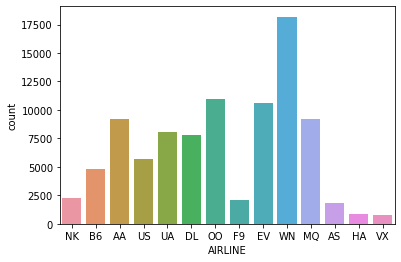

In [159]:
#Ilość opóźnionych lotów dla poszczególnych linii lotniczych
sns.countplot(x="AIRLINE", data=delay)

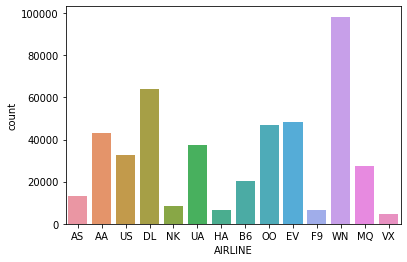

In [160]:
#Ilość wszystkich lotów dla poszczególnych linii lotniczych
sns.countplot(x="AIRLINE", data=flights_copy)

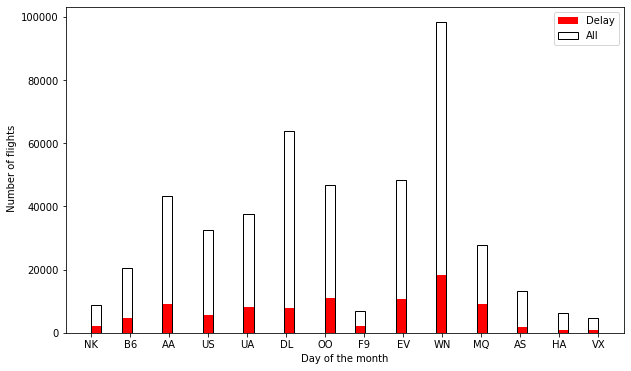

In [161]:
fig, ax = plt.subplots()

ax.hist(delay['AIRLINE'], label='Delay', color = 'red', bins=50)
ax.hist(flights_copy['AIRLINE'], label='All',histtype='step', color='black',bins=50)

fig.set_size_inches(10,6)

ax.set_xlabel('Day of the month')
ax.set_ylabel(' Number of flights')

ax.legend()
plt.show()

###One Hot Encoding

In [162]:
flights_copy = pd.concat([flights_copy, pd.get_dummies(flights_copy['AIRLINE'], drop_first = True)], axis = 1)
flights_copy.drop(['AIRLINE'], axis = 1, inplace = True)

In [163]:
flights_copy

,DAY_OF_WEEK,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,DELAY,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,4,-11.0,21.0,205.0,1448,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4,-8.0,12.0,280.0,2330,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,-2.0,16.0,286.0,2296,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,-5.0,15.0,285.0,2342,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,-1.0,11.0,235.0,1448,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,6,0.0,18.0,221.0,1576,0,0,1,0,0,0,0,0,0,0,0,0,0,0
469964,6,0.0,16.0,252.0,1927,0,0,0,1,0,0,0,0,0,0,0,0,0,0
469965,6,3.0,35.0,192.0,1506,1,0,0,0,0,1,0,0,0,0,0,0,0,0
469966,6,0.0,40.0,162.0,1199,1,0,0,0,0,1,0,0,0,0,0,0,0,0


##Wybór X i y

In [164]:
flights_copy['DELAY'].value_counts()

0    365685
1     92407
Name: DELAY, dtype: int64

In [165]:
X = flights_copy.drop(['DELAY'], axis = 1, inplace = False)
y = flights_copy['DELAY']

In [166]:
features = X.columns

In [167]:
X

,DAY_OF_WEEK,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,4,-11.0,21.0,205.0,1448,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4,-8.0,12.0,280.0,2330,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,-2.0,16.0,286.0,2296,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,-5.0,15.0,285.0,2342,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,-1.0,11.0,235.0,1448,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,6,0.0,18.0,221.0,1576,0,1,0,0,0,0,0,0,0,0,0,0,0
469964,6,0.0,16.0,252.0,1927,0,0,1,0,0,0,0,0,0,0,0,0,0
469965,6,3.0,35.0,192.0,1506,0,0,0,0,1,0,0,0,0,0,0,0,0
469966,6,0.0,40.0,162.0,1199,0,0,0,0,1,0,0,0,0,0,0,0,0


###Wykresy

In [168]:
delay = flights_copy[flights_copy['DELAY']==1]
no_delay = flights_copy[flights_copy['DELAY']==0]

In [169]:
percent = delay['DELAY'].count() / (delay['DELAY'].count() + no_delay['DELAY'].count()) * 100
percent = round(percent,2)
print(f'{percent}% lotów w styczni była opóźniona')

20.17% lotów w styczni była opóźniona


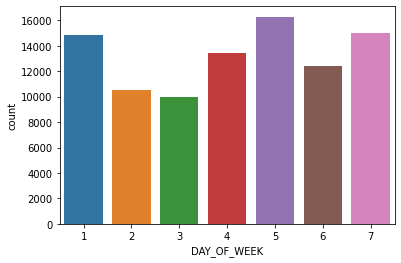

In [170]:
#Ilość opóźnionych dla poszczególnych dni tygodnia
sns.countplot(x="DAY_OF_WEEK", data=delay)

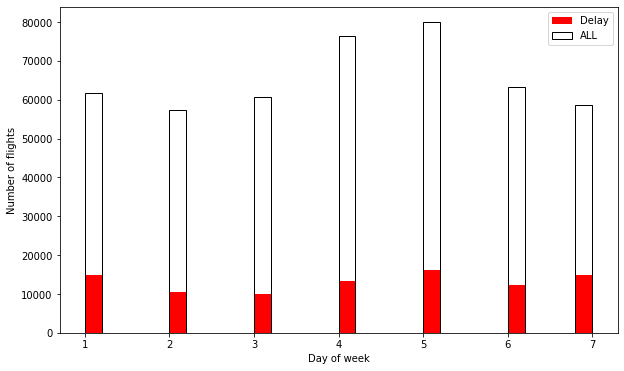

In [171]:
fig, ax = plt.subplots()

ax.hist(delay['DAY_OF_WEEK'], label='Delay', color = 'red',bins=30 )
ax.hist(flights_copy['DAY_OF_WEEK'], label='ALL',histtype='step', color='black',bins=30 )

ax.set_xlabel('Day of week')
ax.set_ylabel('Number of flights')

fig.set_size_inches(10,6)

ax.legend()
plt.show()

In [172]:
flights_copy.groupby(['DAY_OF_WEEK','DELAY'])[['DELAY']].count()

DELAY
DAY_OF_WEEK DELAY       
1           0      46774
            1      14874
2           0      46783
            1      10495
3           0      50851
            1       9962
4           0      63054
            1      13417
5           0      63673
            1      16285
6           0      50905
            1      12384
7           0      43645
            1      14990

In [173]:
flights_copy.groupby(['DAY_OF_WEEK'])[['DELAY']].mean()

,DELAY
DAY_OF_WEEK,
1,0.241273
2,0.183229
3,0.163814
4,0.175452
5,0.203669
6,0.195674
7,0.255649


## Podział, trenowanie, testowanie

In [174]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2, stratify = y) 

In [175]:
y_train.value_counts(normalize=True)

0    0.79828
1    0.20172
Name: DELAY, dtype: float64

In [176]:
y_test.value_counts(normalize=True)

0    0.798273
1    0.201727
Name: DELAY, dtype: float64

In [177]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

### DummyClassifier

In [178]:
def print_binary_evaluation(X_train, X_test,y_train, y_true, strategy):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

In [179]:
print_binary_evaluation(X_train_scaler, X_test_scaler, y_train, y_test, 'uniform')

{'accuracy': 0.5008240648773726,
 'f1_score': 0.28838613306777866,
 'precision': 0.20239811296029353,
 'recall': 0.5014067741586409}

###Regresja Logistyczna

In [180]:
model = LogisticRegression(random_state=2022)
model.fit(X_train_scaler, y_train)

LogisticRegression(random_state=2022)

In [181]:
y_test_prediction = model.predict(X_test_scaler)
print('y test:')
print(y_test[:20].values)
print('y prediction:')
print(y_test_prediction[:20])

y test:
[0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0]
y prediction:
[0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


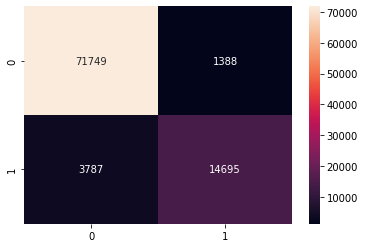

In [194]:
cm_test = confusion_matrix(y_test, y_test_prediction)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

In [183]:
def clasiffication_metrics(true, prediction):
    print(f'Accuracy: {accuracy_score(true, prediction)}')
    print(f'Precision: {precision_score(true, prediction)}')
    print(f'Recall: {recall_score(true, prediction)}')
    print(f'F1-score: {f1_score(true, prediction)}')

clasiffication_metrics(y_test, y_test_prediction)

Accuracy: 0.943516082908567
Precision: 0.9136976932164397
Recall: 0.7950979331241208
F1-score: 0.8502820772457688


###Knn

In [184]:
def clasiffication_metrics_multiclass(true, prediction):
    print(f'Accuracy: {accuracy_score(true, prediction)}')
    print(f'Precision: {precision_score(true, prediction, average="weighted")}')
    print(f'Recall: {recall_score(true, prediction, average="weighted")}')
    print(f'F1-score: {f1_score(true, prediction, average="weighted")}')

In [185]:
# inicializacja modelu
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

# Uczenie modelu
knn_model.fit(X_train_scaler, y_train)
knn_pred = knn_model.predict(X_test_scaler)

clasiffication_metrics_multiclass(y_test, knn_pred)

Accuracy: 0.9352863489014287
Precision: 0.933856224128091
Recall: 0.9352863489014287
F1-score: 0.9335627207339542


###DecisionTreeClassifier



In [186]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [187]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [188]:
clf_pred = clf.predict(X_test)

In [189]:
clasiffication_metrics_multiclass(y_test, clf_pred)

Accuracy: 0.910826356978356
Precision: 0.9116997592936186
Recall: 0.910826356978356
F1-score: 0.9112320009812874


Zapis modelu

In [190]:
import joblib

model_filename = 'knn_model.pkl'
joblib.dump(knn_model, model_filename)

['knn_model.pkl']